This unmodified version is:

* Slower

* Finds a suboptimal answer

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

from torchsummary import summary

In [3]:
# data is from: https://grouplens.org/datasets/movielens/
# in case the link changes in the future

!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

File ‘ml-20m.zip’ already there; not retrieving.



In [4]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip


In [5]:
!ls

ml-20m	ml-20m.zip  sample_data


In [6]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [7]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#   global current_user_id, custom_user_map
#   old_user_id = row['userId']
#   if old_user_id not in custom_user_map:
#     custom_user_map[old_user_id] = current_user_id
#     current_user_id += 1
#   return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [8]:
# Now do the same thing for movie ids
# current_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#   global current_movie_id, custom_movie_map
#   old_movie_id = row['movieId']
#   if old_movie_id not in custom_movie_map:
#     custom_movie_map[old_movie_id] = current_movie_id
#     current_movie_id += 1
#   return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [9]:
# Get user IDs, movie IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [10]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [11]:
# Make a neural network
class Model(nn.Module):
  def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
    super(Model, self).__init__()
    self.N = n_users
    self.M = n_items
    self.D = embed_dim

    self.u_emb = nn.Embedding(self.N, self.D)
    self.m_emb = nn.Embedding(self.M, self.D)
    self.fc1 = nn.Linear(2 * self.D, n_hidden)
    self.fc2 = nn.Linear(n_hidden, 1)
  
  def forward(self, u, m):
    u = self.u_emb(u) # output is (num_samples, D)
    m = self.m_emb(m) # output is (num_samples, D)

    # merge
    out = torch.cat((u, m), 1) # output is (num_samples, 2D)

    # ANN
    out = self.fc1(out)
    out = F.relu(out)
    out = self.fc2(out)
    return out

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [14]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
# optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [15]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [16]:
# convert to tensors
user_ids_t = torch.from_numpy(user_ids).long()
movie_ids_t = torch.from_numpy(movie_ids).long()
ratings_t = torch.from_numpy(ratings)

In [17]:
# Make datasets
Ntrain = int(0.8 * len(ratings))
train_dataset = torch.utils.data.TensorDataset(
    user_ids_t[:Ntrain],
    movie_ids_t[:Ntrain],
    ratings_t[:Ntrain],
)

test_dataset = torch.utils.data.TensorDataset(
    user_ids_t[Ntrain:],
    movie_ids_t[Ntrain:],
    ratings_t[Ntrain:],
)

In [18]:
# Data loaders
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [19]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for users, movies, targets in train_loader:
      targets = targets.view(-1, 1).float()

      # move data to GPU
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for users, movies, targets in test_loader:
      users, movies, targets = users.to(device), movies.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(users, movies)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [ ]:
# train_losses, test_losses = batch_gd(
#     model, criterion, optimizer, train_loader, test_loader, 25)

In [ ]:
# profile this using
%prun train_losses, test_losses = batch_gd( \
    model, criterion, optimizer, train_loader, test_loader, 25)

Epoch 1/25, Train Loss: 0.8178, Test Loss: 0.7534, Duration: 0:05:46.708259
Epoch 2/25, Train Loss: 0.7389, Test Loss: 0.7373, Duration: 0:05:48.753728
Epoch 3/25, Train Loss: 0.7216, Test Loss: 0.7229, Duration: 0:05:49.130197
Epoch 4/25, Train Loss: 0.7065, Test Loss: 0.7132, Duration: 0:05:49.181215


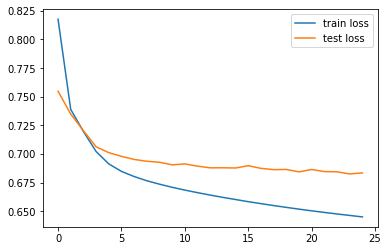

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()